get dataset

In [1]:
# !wget https://github.com/alexeygrigorev/large-datasets/releases/download/dogs-cats/train.zip

In [2]:
import shutil
import glob

import os
import re

import numpy as np

In [3]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 15, 8
# %matplotlib inline

In [5]:
shutil.unpack_archive('train.zip', '')

* Create a `train` and `validation` folders
* In each folder, create `cats` and `dogs` folders

In [6]:
!mkdir train/cats
!mkdir train/dogs

!mkdir validation
!mkdir validation/cats
!mkdir validation/dogs

In [7]:
val_cats_folder = 'validation/cats'
train_cats_folder = 'train/cats'

val_dogs_folder = 'validation/dogs'
train_dogs_folder = 'train/dogs'

In [8]:
all_files = glob.glob('train/*.jpg')

* Move the first 10,000 images to the train folder (from 0 to 9999) for boths cats and dogs - and put them in respective folders
* Move the remaining 2,500 images to the validation folder (from 10000 to 12499)

In [9]:
for f in all_files:
    if 'cat' in f:
        _number_cat = int(re.findall(r'\d+', f)[0])
        if _number_cat < 10000:
            shutil.move(f, train_cats_folder)
        else:
            shutil.move(f, val_cats_folder)
        
    elif 'dog' in f:
        _number_dog = int(re.findall(r'\d+', f)[0])
        if _number_dog < 10000:
            shutil.move(f, train_dogs_folder)
        else:
            shutil.move(f, val_dogs_folder)

### Question 1

Since we have a binary classification problem, what is the best loss function for us?

* mean squared error
* categorical cross-entropy
* **binary cross-entropy**

### Question 2

What's the total number of parameters of the model? You can use the summary method for that.

In [10]:
# neural network architecture (functional style)
inputs = keras.Input(shape=(150, 150, 3))

layer = keras.layers.Conv2D(32, 3, activation='relu')(inputs)
pool = keras.layers.MaxPooling2D(pool_size=(2, 2))(layer)
vectors = keras.layers.Flatten()(pool)
inner = keras.layers.Dense(64, activation='relu')(vectors)
outputs = keras.layers.Dense(1, activation='sigmoid')(inner)

model = keras.Model(inputs, outputs)

2021-11-18 23:22:05.429620: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                             

**Answer: 11_215_873**

## Generators and Training


For the next two questions, use the following data generator for both train and validation:

`ImageDataGenerator(rescale=1./255)`

* We don't need to do any additional pre-processing for the images.
* When reading the data from train/val directories, check the `class_mode` parameter. Which value should it be for a binary classification problem?
* Use `batch_size=20`

For training use `.fit()` with the following params:

```
model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50
)
```

In [12]:
train_generator = ImageDataGenerator(rescale=1./255)

train_ds = train_generator.flow_from_directory('train', 
                                               target_size=(150, 150), 
                                               batch_size=20, 
                                               class_mode='binary')

Found 20000 images belonging to 2 classes.


In [13]:
train_ds.class_indices

{'cats': 0, 'dogs': 1}

In [14]:
val_generator = ImageDataGenerator(rescale=1./255)

val_ds = val_generator.flow_from_directory('validation', 
                                           target_size=(150, 150), 
                                           batch_size=20, 
                                           class_mode='binary', 
                                           shuffle=False)

Found 5000 images belonging to 2 classes.


In [15]:
val_ds.class_indices

{'cats': 0, 'dogs': 1}

In [16]:
optimizer = keras.optimizers.SGD(learning_rate=0.002, momentum=0.8)

loss = keras.losses.BinaryCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [17]:
history = model.fit(train_ds, 
                    steps_per_epoch=100, 
                    epochs=10, 
                    validation_data=val_ds, 
                    validation_steps=50)

Epoch 1/10
100/100 [==============================] - 18s 177ms/step - loss: 0.7038 - accuracy: 0.5145 - val_loss: 0.7977 - val_accuracy: 0.0590
Epoch 2/10
100/100 [==============================] - 18s 178ms/step - loss: 0.6858 - accuracy: 0.5590 - val_loss: 0.7881 - val_accuracy: 0.1810
Epoch 3/10
100/100 [==============================] - 18s 182ms/step - loss: 0.6748 - accuracy: 0.5690 - val_loss: 0.9001 - val_accuracy: 0.1390
Epoch 4/10
100/100 [==============================] - 18s 178ms/step - loss: 0.6672 - accuracy: 0.5950 - val_loss: 0.8694 - val_accuracy: 0.2190
Epoch 5/10
100/100 [==============================] - 18s 177ms/step - loss: 0.6716 - accuracy: 0.5860 - val_loss: 0.4153 - val_accuracy: 0.9840
Epoch 6/10
100/100 [==============================] - 18s 176ms/step - loss: 0.6696 - accuracy: 0.5760 - val_loss: 0.3606 - val_accuracy: 0.9970
Epoch 7/10
100/100 [==============================] - 17s 173ms/step - loss: 0.6657 - accuracy: 0.5905 - val_loss: 0.4580 - val_ac

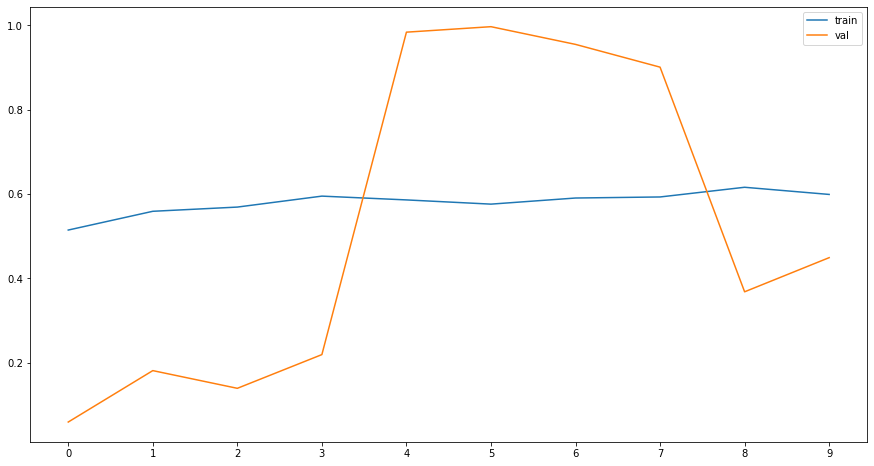

In [18]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(range(10))
plt.legend()
plt.show();

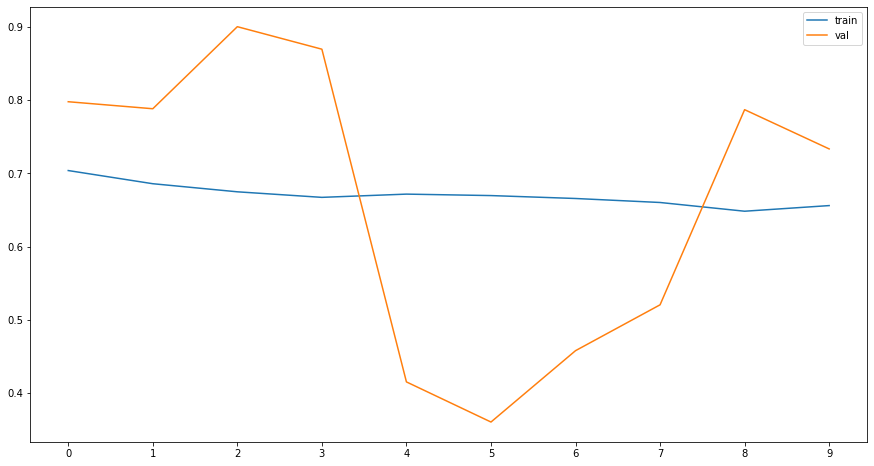

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xticks(range(10))
plt.legend()
plt.show();

### Question 3

What is the median of training accuracy for this model?

In [20]:
np.median(history.history['accuracy']).round(3)

0.588

### Question 4

What is the standard deviation of training loss for this model?

In [21]:
np.std(history.history['loss']).round(3)

0.015

### Data Augmentation

For the next two questions, we'll generate more data using data augmentations. 

Add the following augmentations to your training data generator:

* `rotation_range=40,`
* `width_shift_range=0.2,`
* `height_shift_range=0.2,`
* `shear_range=0.2,`
* `zoom_range=0.2,`
* `horizontal_flip=True,`
* `fill_mode='nearest'`

### Question 5 

Let's train our model for 10 more epochs using the same code as previously.
Make sure you don't re-create the model - we want to continue training the model
we already started training.

What is the mean of validation loss for the model trained with augmentations?

In [22]:
train_generator_aug = ImageDataGenerator(rescale=1./255,
                                         rotation_range=40,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         fill_mode='nearest')

train_ds_aug = train_generator_aug.flow_from_directory('train', 
                                                       target_size=(150, 150), 
                                                       batch_size=20, 
                                                       class_mode='binary')

Found 20000 images belonging to 2 classes.


In [23]:
val_generator_aug = ImageDataGenerator(rescale=1./255,
                                         rotation_range=40,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         fill_mode='nearest')

val_ds_aug = val_generator_aug.flow_from_directory('validation', 
                                                   target_size=(150, 150), 
                                                   batch_size=20, 
                                                   class_mode='binary', 
                                                   shuffle=False)

Found 5000 images belonging to 2 classes.


In [24]:
history_aug = model.fit(train_ds_aug, 
                        steps_per_epoch=100, 
                        epochs=10, 
                        validation_data=val_ds_aug, 
                        validation_steps=50)

Epoch 1/10
100/100 [==============================] - 32s 318ms/step - loss: 0.6650 - accuracy: 0.5885 - val_loss: 0.6150 - val_accuracy: 0.7490
Epoch 2/10
100/100 [==============================] - 33s 326ms/step - loss: 0.6662 - accuracy: 0.5960 - val_loss: 0.6925 - val_accuracy: 0.5490
Epoch 3/10
100/100 [==============================] - 33s 327ms/step - loss: 0.6661 - accuracy: 0.5795 - val_loss: 0.5865 - val_accuracy: 0.7990
Epoch 4/10
100/100 [==============================] - 36s 362ms/step - loss: 0.6545 - accuracy: 0.6030 - val_loss: 0.6175 - val_accuracy: 0.7320
Epoch 5/10
100/100 [==============================] - 35s 346ms/step - loss: 0.6559 - accuracy: 0.6070 - val_loss: 0.8967 - val_accuracy: 0.1610
Epoch 6/10
100/100 [==============================] - 32s 322ms/step - loss: 0.6634 - accuracy: 0.5950 - val_loss: 0.6130 - val_accuracy: 0.7640
Epoch 7/10
100/100 [==============================] - 32s 323ms/step - loss: 0.6466 - accuracy: 0.6110 - val_loss: 0.5822 - val_ac

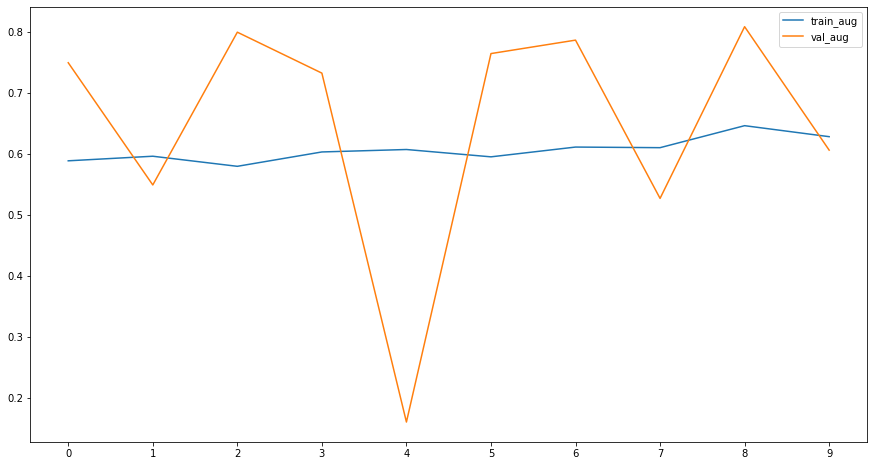

In [25]:
plt.plot(history_aug.history['accuracy'], label='train_aug')
plt.plot(history_aug.history['val_accuracy'], label='val_aug')
plt.xticks(range(10))
plt.legend()
plt.show();

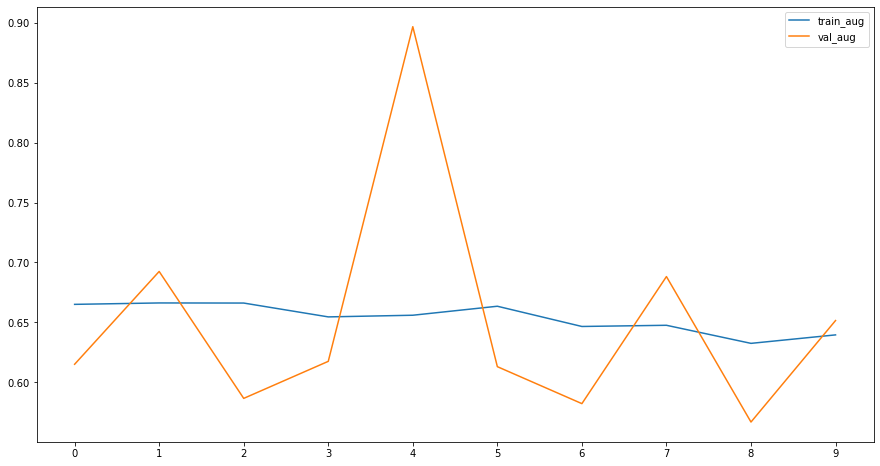

In [26]:
plt.plot(history_aug.history['loss'], label='train_aug')
plt.plot(history_aug.history['val_loss'], label='val_aug')
plt.xticks(range(10))
plt.legend()
plt.show();